# NMF Analysis

Performs a simple tf-idf of the question pairs and NMF dimension reduction to calculate cosine similarity of each question pair. The goal of the analysis is to see if the pairs labeled as duplicates have a distinctly different cosine similarity compared to those pairs marked as not duplicates.

In [1]:
# data manipulation
from utils import save, load
import pandas as pd

# modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline

In [2]:
train_df = load('train')
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66.0,57.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51.0,88.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73.0,59.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50.0,65.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76.0,39.0


Let's make a stack of questions maintaining the `id` of the question pair.

In [3]:
question_df = train_df.loc[:, ['id', 'question1']]
question_df = question_df.append(train_df.loc[:,['id', 'question2']], sort=False)
question_df.loc[question_df['question1'].isna(), 'question1'] = question_df.loc[question_df['question1'].isna(), 'question2']
question_df = question_df.drop(columns='question2')
question_df = question_df.sort_values('id')
question_df.head(6)

,id,question1
0,0,What is the step by step guide to invest in sh...
0,0,What is the step by step guide to invest in sh...
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...
1,1,What would happen if the Indian government sto...
2,2,How can I increase the speed of my internet co...
2,2,How can Internet speed be increased by hacking...


Let's now calcualte the tf-idf term matrix.

In [4]:
tf = TfidfVectorizer(stop_words='english', token_pattern='\\b[a-zA-Z0-9][a-zA-Z0-9]+\\b')

question_tf = tf.fit_transform(question_df['question1'])

In [5]:
# first 10 terms
tf.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '000000',
 '00000000',
 '0000000000',
 '0000001',
 '00000074',
 '0000021210',
 '00001']

In [6]:
# last 10 terms
tf.get_feature_names()[-10:]

['zyl',
 'zylber',
 'zynga',
 'zyropathy',
 'zyrtec',
 'zyzz',
 'zz',
 'zzz',
 'zzzquil',
 'zzzz']

In [7]:
# total terms
len(tf.get_feature_names())

84697

Lots of words, but some cleanup will probably needed given the numbers, and what appears to be Korean characters.

Let's now reduce the 84,697 term matrix utilizing NMF.

In [8]:
def calc_NMF_sim(n_components, col_name, tf_df, df):
    nmf = NMF(n_components=n_components)

    nmf_topics = nmf.fit_transform(tf_df)

    odd_idx = [i for i in range(nmf_topics.shape[0]) if i % 2 == 1]
    even_idx = [i for i in range(nmf_topics.shape[0]) if i % 2 == 0]

    sim_list = [cosine_similarity(
                                    nmf_topics[odd_idx[i]].reshape(1,-1),
                                    nmf_topics[even_idx[i]].reshape(1,-1)
                )[0,0]
                for i in range(len(odd_idx))]

    df = pd.concat([df.sort_values('id'), pd.Series(sim_list)], axis=1)
    df = df.rename(columns={0:col_name})
    
    return df

In [9]:
train_df_cosine = calc_NMF_sim(5, 'cos_sim_5', question_tf, train_df.reset_index())
train_df_cosine = calc_NMF_sim(10, 'cos_sim_10', question_tf, train_df_cosine)
train_df_cosine = calc_NMF_sim(50, 'cos_sim_50', question_tf, train_df_cosine)
train_df_cosine = calc_NMF_sim(100, 'cos_sim_100', question_tf, train_df_cosine)

In [10]:
train_df_cosine.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,cos_sim_5,cos_sim_10,cos_sim_50,cos_sim_100
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66.0,57.0,0.588363,0.671389,0.294667,0.342805
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51.0,88.0,0.835320,0.276426,0.041272,0.027379
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73.0,59.0,0.955012,0.680507,0.589208,0.481864
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50.0,65.0,0.889749,0.448912,0.070662,0.963472
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76.0,39.0,0.994702,0.996884,0.971567,0.919735


We calcualted the cosine similarity for 5, 10, 50, and 100 dimensional dimensional NMF. Let's now plot the distribution for the duplicate pairs and not duplicate pairs. The goal is to see if there is a natural division based purely on the cosine similarity between the pair of questions.

/anaconda3/envs/project5/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


''

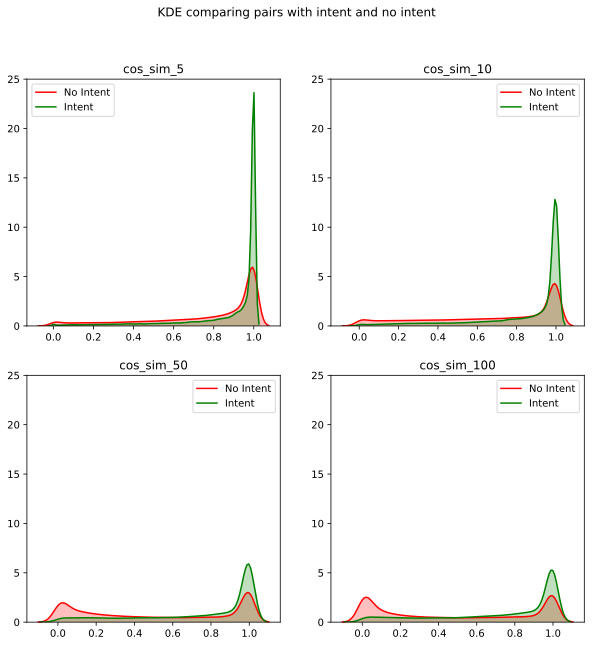

In [11]:
cols = ['cos_sim_5', 'cos_sim_10', 'cos_sim_50', 'cos_sim_100']
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(train_df_cosine.loc[train_df_cosine['is_duplicate'] == 0, cols[i]], 
                 shade=True, 
                 label = 'No Intent',
                 color = 'red')
    sns.kdeplot(train_df_cosine.loc[train_df_cosine['is_duplicate'] == 1, cols[i]], 
                 shade=True,
                 label = 'Intent',
                 color = 'green')
    plt.title(cols[i])
    plt.ylim(top=25)

# plt.xlabel('cosine similarity')
# plt.ylabel('density')
plt.suptitle('KDE comparing pairs with intent and no intent')
;

More of the duplicate pairs have a higher cosine similarity compared to the non-duplicate pairs. However, there is also significant overlap, which means finding the decision boundary will be difficult.

Let's take a look at the set of pairs marked as duplicates with a 0 cosine similarity with the NMF 100 transformation.

In [12]:
train_df_cosine[(train_df_cosine['is_duplicate'] == 1) & (train_df_cosine['cos_sim_100'] == 0)]

,index,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,cos_sim_5,cos_sim_10,cos_sim_50,cos_sim_100
7,7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,30.0,41.0,0.859460,0.333265,0.001372,0.0
405,405,405,808,809,What are movies with incest scenes?,Are there any good incest movie?,1,35.0,32.0,0.266816,0.189486,0.000000,0.0
3525,3526,3526,6986,6987,What does agape mean?,What is agape (love)?,1,21.0,21.0,0.582432,0.000000,0.000000,0.0
4123,4124,4124,8159,8160,Which are the movies with incest themes?,Which is best incest movie?,1,40.0,27.0,0.999694,0.997471,0.000000,0.0
7819,7820,7820,15264,15265,Why and how is 0! =1?,Why is 0! equal to 1?,1,21.0,21.0,0.000000,0.000000,0.000000,0.0
9573,9574,9574,18595,18596,What is human body made up of?,What are you made of?,1,30.0,21.0,0.000000,0.000000,0.000000,0.0
11336,11337,11337,21899,21900,What does Netlogon do?,What is NetLogon used for?,1,22.0,26.0,0.746044,0.413419,0.019149,0.0
12462,12463,12463,24010,24011,How do I find out if I have a warrent?,How do I find out about a warrent?,1,38.0,34.0,0.000000,0.000000,0.000000,0.0
16855,16857,16857,32097,32098,How can you learn Hadoop?,What is essential to start learning Hadoop?,1,25.0,43.0,0.849793,0.979388,0.000000,0.0
18383,18385,18385,34838,34839,What did Barney Rubble do for a living?,What is Barney Rubble's job?,1,39.0,28.0,0.743883,0.141906,0.000000,0.0


The first example is very confusing. This may be a result of the tf-idf calculation with default parameters is incorrect, or the cosine similarity is not the best metric. The next step would be to build a classification model using NMF or LDA topics for the pair of questions to predict whether or not the pair has the same intent.